### 필요모듈 불러오기

In [1]:
# 데이터 불러오고 압축해제
import requests
import zipfile

# 데이터 전처리
import pandas as pd
import numpy as np

# train_test_split
from sklearn.model_selection import train_test_split

# 경고 무시 모듈
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# task 2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# task 4
from soyclustering import SphericalKMeans
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# task 5
from sklearn.decomposition import PCA

### Task 1. 데이터 준비하기

- Task 1-1. 파일을 다운로드 받고 (requests, zipfile 사용), ratings.csv 파일을 읽어서 80%
20% 비율의 train, test 데이터로 나누기


In [2]:
# request를 사용하여 url을 통해 파일을 다운받는 함수 생성
def download(url, file_name = None):
    if not file_name:
        file_name = url.split('/')[-1] # url에 있는 파일 이름으로 다운로드 ( ml-latest.zip ) 

    with open(file_name, "wb") as file:   
            response = requests.get(url)               
            file.write(response.content)      

if __name__ == '__main__':
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    download(url)

In [3]:
# zipfile을 사용하여 압축 해제
output_unzip = zipfile.ZipFile("ml-latest-small.zip", "r")  # "r": read 모드
output_unzip.extractall()
output_unzip.close()

In [4]:
# 데이터가 저장된 경로 설정
data_path = './ml-latest-small/'

# 데이터 불러오기
ratings = pd.read_csv(data_path+'ratings.csv')

In [5]:
# train과 test를 8:2의 비율로 나누기
train, test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=0)

- Task 1-2. movies.csv 파일을 읽고, 장르를 집합으로 변환하기

In [6]:
# 데이터 불러오기
movies = pd.read_csv(data_path+'movies.csv')
# 장르를 집합으로 변경
movies['genres'] = movies['genres'].apply(lambda x: set(x.split('|')))

- Task 1-3. tags.csv 파일을 읽고, tag들을 모두 소문자로 변환 후, 영화별로 tag들을 묶어서
집합으로 변환하기 

In [7]:
# 데이터 불러오기
tags = pd.read_csv(data_path+'tags.csv')

In [8]:
# 소문자로 변경 ( tag가 float인 tag가 존재하기 때문에 이런경우는 그냥 리턴 )
tags['tag'] = tags['tag'].apply(lambda x: x.lower() if type(x) == str else x)

In [9]:
# movieId 별로 tag 집합 생성
tag_set = tags.groupby('movieId')['tag'].apply(set);pd.DataFrame(tag_set)

,tag
movieId,
1,"{fun, pixar}"
2,"{game, magic board game, robin williams, fantasy}"
3,"{old, moldy}"
5,"{pregnancy, remake}"
7,{remake}
...,...
183611,"{rachel mcadams, funny, comedy}"
184471,"{adventure, alicia vikander, video game adapta..."
187593,"{ryan reynolds, sarcasm, josh brolin}"


### Task 2. Latent Factor 모델을 이용하여 학습하기

- Task 2-1. P, Q 등 파라미터 초기화 후, optimizer 등을 이용해서 학습하기

In [10]:
# 텐서로 변경
items = torch.LongTensor([i for i in train['movieId']])
users = torch.LongTensor([i for i in train['userId']])
rating = torch.FloatTensor([i for i in train['rating']])

items_test = torch.LongTensor([i for i in test['movieId']])
users_test = torch.LongTensor([i for i in test['userId']])
rating_test = torch.FloatTensor([i for i in test['rating']])

In [11]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

In [12]:
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [13]:
# Regularization추가하기
lambda1 = 0.00035
lambda2 = 0.0001
lambda3 = 0.000035
lambda4 = 0.00001

# bias 추가
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (rating.sum() / len(rating)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.05)

#그래프 그려보기 위해 저장
X = []
Y = []
Y_test = []

for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,rating)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_train = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
        
        
        cost_train = np.sqrt(F.mse_loss(hypo_train, rating))
        cost_test = np.sqrt(F.mse_loss(hypo_test, rating_test))
        Y_test.append(cost_test)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.10f}, train_rmse: {:.10f}, test_rmse: {:.10f}" .format(epoch, cost.item(),cost_train, cost_test))

epoch: 0, cost: 14.0994138718, train_rmse: 3.4846687317, test_rmse: 3.5030674934
epoch: 100, cost: 0.5888507366, train_rmse: 0.7668959498, test_rmse: 0.8754818439
epoch: 200, cost: 0.5296276808, train_rmse: 0.7275682092, test_rmse: 0.8679994345
epoch: 300, cost: 0.5107439160, train_rmse: 0.7145736217, test_rmse: 0.8645431399
epoch: 400, cost: 0.5019251108, train_rmse: 0.7084277272, test_rmse: 0.8625626564
epoch: 500, cost: 0.4980359375, train_rmse: 0.7056968212, test_rmse: 0.8613660336
epoch: 600, cost: 0.4959010780, train_rmse: 0.7041903138, test_rmse: 0.8605996966
epoch: 700, cost: 0.4944955707, train_rmse: 0.7031967640, test_rmse: 0.8600432277
epoch: 800, cost: 0.4935325682, train_rmse: 0.7025125623, test_rmse: 0.8596073985
epoch: 900, cost: 0.4928950667, train_rmse: 0.7020601630, test_rmse: 0.8592808247


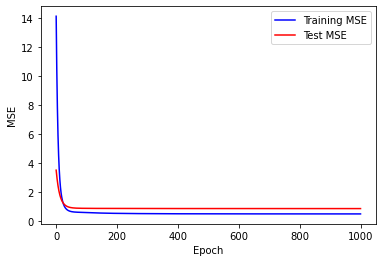

In [14]:
# Matplotlib으로epoch마다TrainingMSE그려보기
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### Task 3. 514번 User에게 추천하기 (knn search, similarity)

- Task 3-1. 514번 user의 예상 별점이 가장 높은 영화 20개를 찾아서 id 및 영화 이름
출력하기

In [15]:
# Latent Factor model을 이용하여 별점 예측
# 514번 유져의 인덱스 확인
list(users).index(514),list(users_test).index(514)

(206, 270)

In [16]:
hypo_train_514 = torch.sum(P[items] * Q[206], dim=1) + mean + bias_item[items] + bias_user[206]
hypo_test_514 = torch.sum(P[items_test] * Q[270], dim=1) + mean + bias_item[items_test] + bias_user[270]

In [17]:
# train
train_514 = pd.DataFrame(hypo_train_514).astype(float)
train_514['movieId'] = train['movieId'].reset_index(drop=True)
train_514 = train_514[['movieId', 0]]
# test
test_514 = pd.DataFrame(hypo_test_514).astype(float)
test_514['movieId'] = test['movieId'].reset_index(drop=True)
test_514 = test_514[['movieId', 0]]

In [18]:
# 514의 예상별점 뽑기
pred_514 = pd.concat([train_514, test_514])
pred_514 = pred_514.drop_duplicates('movieId').reset_index(drop=True)
# data로 만듦
data = pd.merge(movies,pred_514, how='left', on='movieId')[['movieId', 'title', 0]]

In [19]:
# 예상별점순으로 상위 20개 영화 정렬
seen_list = list(ratings.query('userId == 514')['movieId'])
data.query('movieId not in @seen_list').sort_values(by=[0], axis=0, ascending=False).iloc[:20,:]

,movieId,title,0
2582,3451,Guess Who's Coming to Dinner (1967),4.846028
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",4.839806
277,318,"Shawshank Redemption, The (1994)",4.786158
731,951,His Girl Friday (1940),4.756495
937,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",4.750024
694,912,Casablanca (1942),4.709698
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.700595
2462,3275,"Boondock Saints, The (2000)",4.692386
9570,174053,Black Mirror: White Christmas (2014),4.683300
4590,6818,Come and See (Idi i smotri) (1985),4.678341


In [20]:
# 이후 5-3-2에 쓰임
df_3_1 = data.query('movieId not in @seen_list').sort_values(by=[0], axis=0, ascending=False).iloc[:20,:]

- Task 3-2. (10 점) 장르 및 tag를 기준으로, 514번 user가 5점을 준 영화들을 찾고, 각각의 영화와
가장 유사한 영화를 5개씩 찾아서 id, 영화 이름, 유사도 점수 출력하기


In [21]:
# 장르와 tag를 합쳐서 df를 만듦
meta = pd.merge(movies, tag_set, on='movieId', how='inner')

In [22]:
# 514번 유져가 5점을 준 영화들
movie_5_list = list(ratings.query('userId == 514 and rating == 5.0')['movieId'])
# meta에서 찾아서 뽑음
movie_5 = meta.query('movieId in @movie_5_list').reset_index(drop=True);movie_5

,movieId,title,genres,tag
0,260,Star Wars: Episode IV - A New Hope (1977),"{Action, Adventure, Sci-Fi}","{engrossing adventure, space adventure, space,..."
1,593,"Silence of the Lambs, The (1991)","{Crime, Horror, Thriller}","{suspense, drama, gothic, disturbing, psycholo..."
2,1196,Star Wars: Episode V - The Empire Strikes Back...,"{Action, Adventure, Sci-Fi}","{george lucas, sci-fi, music, harrison ford, s..."
3,1197,"Princess Bride, The (1987)","{Fantasy, Romance, Action, Adventure, Comedy}","{inigo montoya, six-fingered man}"
4,1198,Raiders of the Lost Ark (Indiana Jones and the...,"{Action, Adventure}","{treasure hunt, adventure, archaeology, steven..."
5,1200,Aliens (1986),"{Action, Adventure, Sci-Fi, Horror}","{space travel, space craft, sci-fi, suspense, ..."
6,1270,Back to the Future (1985),"{Adventure, Sci-Fi, Comedy}",{time travel}
7,1302,Field of Dreams (1989),"{Fantasy, Children, Drama}",{baseball}
8,1387,Jaws (1975),"{Action, Horror}",{shark}
9,6979,WarGames (1983),"{Thriller, Sci-Fi, Drama}",{cold war}


In [23]:
#자카드 유사도를 구하는 함수를 생성
def jaccard_similarity(s1, s2):
    if len(s1|s2) == 0:
        return 0
    return len(s1&s2)/len(s1|s2)

In [24]:
#자카드 유사도를 구함
for j in range(len(movie_5)):
    # 자카드 유사도를 구한 리스트 생성 (15개 생성)
    globals()[f'list_{j}'] = []
    for i in range(len(meta)):
        globals()[f'list_{j}'].append(jaccard_similarity(meta.iloc[i].genres|meta.iloc[i].tag, movie_5.iloc[j].genres|movie_5.iloc[j].tag))

In [25]:
# 위에서 구한 유사도를 df로 만들어줌
df_similar = pd.Series(list_0)
for i in range(1,len(movie_5)):
    df_similar = pd.concat([df_similar, pd.Series(globals()[f'list_{i}'])], axis=1)
# 열이름을 바꾸어줌
df_similar.columns = [i for i in range(len(movie_5))]
# 메타에 유사도를 합친 df생성
meta = pd.concat([meta, df_similar], axis=1)

In [26]:
# 0번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[0]['title'])
meta.sort_values(by=[0], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 0]]

Star Wars: Episode IV - A New Hope (1977)


,movieId,title,0
299,1210,Star Wars: Episode VI - Return of the Jedi (1983),0.285714
288,1196,Star Wars: Episode V - The Empire Strikes Back...,0.259259
1315,33493,Star Wars: Episode III - Revenge of the Sith (...,0.238095
291,1200,Aliens (1986),0.222222
1570,187595,Solo: A Star Wars Story (2018),0.173913


In [27]:
# 1번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[1]['title'])
meta.sort_values(by=[1], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 1]]

Silence of the Lambs, The (1991)


,movieId,title,1
853,4725,Session 9 (2001),0.363636
1003,6323,Identity (2003),0.272727
153,628,Primal Fear (1996),0.266667
1252,8957,Saw (2004),0.266667
10,22,Copycat (1995),0.250000


In [28]:
# 2번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[2]['title'])
meta.sort_values(by=[2], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 2]]

Star Wars: Episode V - The Empire Strikes Back (1980)


,movieId,title,2
1315,33493,Star Wars: Episode III - Revenge of the Sith (...,0.384615
299,1210,Star Wars: Episode VI - Return of the Jedi (1983),0.266667
65,260,Star Wars: Episode IV - A New Hope (1977),0.259259
291,1200,Aliens (1986),0.250000
1423,68358,Star Trek (2009),0.238095


In [29]:
# 3번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[3]['title'])
meta.sort_values(by=[3], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 3]]

Princess Bride, The (1987)


,movieId,title,3
1034,6539,Pirates of the Caribbean: The Curse of the Bla...,0.500000
137,552,"Three Musketeers, The (1993)",0.500000
1276,26776,Porco Rosso (Crimson Pig) (Kurenai no buta) (1...,0.444444
1400,59103,"Forbidden Kingdom, The (2008)",0.444444
101,380,True Lies (1994),0.444444


In [30]:
# 4번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[4]['title'])
meta.sort_values(by=[4], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 4]]

Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


,movieId,title,4
505,2115,Indiana Jones and the Temple of Doom (1984),0.333333
352,1291,Indiana Jones and the Last Crusade (1989),0.333333
1568,184471,Tomb Raider (2018),0.272727
1039,6564,Lara Croft Tomb Raider: The Cradle of Life (2003),0.230769
649,3030,Yojimbo (1961),0.222222


In [31]:
# 5번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[5]['title'])
meta.sort_values(by=[5], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 5]]

Aliens (1986)


,movieId,title,5
1423,68358,Star Trek (2009),0.315789
171,780,Independence Day (a.k.a. ID4) (1996),0.307692
1315,33493,Star Wars: Episode III - Revenge of the Sith (...,0.307692
592,2660,"Thing from Another World, The (1951)",0.250000
288,1196,Star Wars: Episode V - The Empire Strikes Back...,0.250000


In [32]:
# 6번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[6]['title'])
meta.sort_values(by=[6], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 6]]

Back to the Future (1985)


,movieId,title,6
339,1270,Back to the Future (1985),1.0
841,4571,Bill & Ted's Excellent Adventure (1989),1.0
642,2968,Time Bandits (1981),0.8
874,4980,Bill & Ted's Bogus Journey (1991),0.8
675,3175,Galaxy Quest (1999),0.6


In [33]:
# 7번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[7]['title'])
meta.sort_values(by=[7], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 7]]

Field of Dreams (1989)


,movieId,title,7
947,5971,My Neighbor Totoro (Tonari no Totoro) (1988),0.500000
226,953,It's a Wonderful Life (1946),0.500000
147,594,Snow White and the Seven Dwarfs (1937),0.428571
1274,26662,Kiki's Delivery Service (Majo no takkyûbin) (1...,0.428571
662,3098,"Natural, The (1984)",0.400000


In [34]:
# 8번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[8]['title'])
meta.sort_values(by=[8], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 8]]

Jaws (1975)


,movieId,title,8
384,1389,Jaws 3-D (1983),1.000000
1028,6502,28 Days Later (2002),0.400000
516,2167,Blade (1998),0.400000
1320,34323,"Devil's Rejects, The (2005)",0.400000
891,5254,Blade II (2002),0.333333


In [35]:
# 9번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[9]['title'])
meta.sort_values(by=[9], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 9]]

WarGames (1983)


,movieId,title,9
328,1253,"Day the Earth Stood Still, The (1951)",0.600000
295,1206,"Clockwork Orange, A (1971)",0.500000
420,1653,Gattaca (1997),0.428571
1461,91500,The Hunger Games (2012),0.428571
173,805,"Time to Kill, A (1996)",0.400000


In [36]:
# 10번째 기준으로 뽑되 유사도 1인 것은 같은 영화이기 때문에 제외
print(movie_5.iloc[10]['title'])
meta.sort_values(by=[10], axis=0, ascending=False).iloc[1:6,:][['movieId', 'title', 10]]

Social Network, The (2010)


,movieId,title,10
1543,148626,"Big Short, The (2015)",0.333333
1098,6981,"Ordet (Word, The) (1955)",0.200000
158,670,"World of Apu, The (Apur Sansar) (1959)",0.200000
1157,7479,Watch on the Rhine (1943),0.200000
1506,113705,"Two Days, One Night (Deux jours, une nuit) (2014)",0.200000


### Task 4. 영화 클러스터링하기 (k-means clustering)

- Task 4-1. cosine similarity를 기준으로 영화 벡터 (P혹은 Q)에서 k-means clustering
구하기 (k=1, ..., 40 까지 바꿔가면서 cost 값을 계산)

In [37]:
P_ratings = P.detach().numpy()

In [38]:
# ratings에 한번이라도 등장한 영화만 추리기
ratings_set = set(ratings['movieId'])
P_ratings = pd.DataFrame(P_ratings).reset_index().query('index in @ratings_set').drop('index', axis=1)
# array로 변경해줌
P_ratings = np.array(P_ratings.astype(float))

# array로 변경해줌
Q_ratings = Q.detach().numpy()

In [39]:
# sklearn module 중에 코사인 유사도를 통해 kmeans해주는 모듈이 있음

In [40]:
X = []
Y = []
for i in range(2,41):
    X.append(i)
    spherical_kmeans = SphericalKMeans(n_clusters=i)

    spherical_kmeans.fit(csr_matrix(P_ratings))    
    Y.append(spherical_kmeans.inertia_)

- Task 4-2. Task 4-1에서 구한 결과를 matplotlib를 활용하여 그래프로 그린 후 가장 적절해
보이는 k값 선택하기

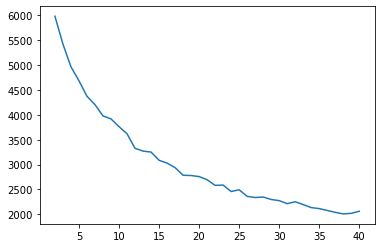

In [41]:
# 그래프를 그림
plt.plot(X,Y)
plt.show()

In [42]:
# 적절한 k=15
spherical_kmeans = SphericalKMeans(n_clusters=15)
spherical_kmeans.fit(csr_matrix(P_ratings))

- Task 4-3. 122912번 영화(Avengers: Infinity War - Part I)와 같은 cluster에 속한 다른 영화
중 cosine similarity가 가장 높은 영화 20개를 찾아서 id, 영화 이름, 유사도 점수 출력하기

In [43]:
# 122912영화가 위에서 만든 cos_data기준으로 인덱스가 얼마인지 확인
list(ratings_set).index(122912)

8342

In [44]:
# 라벨을 확인하기 위하여 데이터프레임으로 변경해줌
df_labels = pd.DataFrame(P_ratings)
df_labels['labels'] = pd.Series(spherical_kmeans.labels_)

# 122912영화의 라벨은 5
label_122912 = df_labels.iloc[8342,:]['labels'];label_122912

5.0

In [45]:
# 동일한 라벨 뽑아서 데이터프레임으로 생성
df_t = df_labels.query('labels == @label_122912').drop('labels', axis=1) # 이제 labels도 필요없으니 제거

df_cos_sim = cosine_similarity(df_t,df_t)
# 영화 찾기 쉽게 인덱스를 위와 맞춰줌, 열이름도 맞춰줌
df_cos_sim = pd.DataFrame(df_cos_sim).set_index(df_t.reset_index()['index'], inplace=False, drop=True)
df_cos_sim.columns = list(df_t.reset_index()['index'])

In [46]:
# top20 개의 영화를 뽑아 ratings_set에 적용하여 movieId를 뽑음
top_20 = df_cos_sim.loc[8342].sort_values(ascending = False)[1:21].reset_index()
top_20['movieId'] = top_20['index'].apply(lambda x: list(ratings_set)[x])
# 사용하기 쉽게 변환
top_20 = top_20[['movieId', 8342]]
top_20.columns = ['movieId','cos_sim']

In [47]:
df_top_20 = pd.merge(movies,top_20, on='movieId', how='inner').sort_values(by=['cos_sim'], axis=0, ascending=False)[['movieId', 'title', 'cos_sim']];df_top_20

,movieId,title,cos_sim
14,97188,Sinister (2012),1.0
17,126430,The Pacific (2010),1.0
12,82744,Faster (2010),1.0
1,27176,Style Wars (1983),1.0
7,55294,Weirdsville (2007),1.0
2,27193,Taxi 2 (2000),1.0
4,27846,"Corporation, The (2003)",1.0
6,31685,Hitch (2005),1.0
5,31433,"Wedding Date, The (2005)",1.0
16,120635,Taken 3 (2015),1.0


### Task 5. 차원 축소 및 시각화 (PCA)

- Task 5-1. P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

In [48]:
Z = torch.cat([torch.tensor(P_ratings),torch.tensor(Q_ratings)],axis=0)

- Task 5-2. Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기

In [49]:
# 중심 옮기기
Z = (Z-torch.mean(Z, axis=0))

In [50]:
pca = PCA(n_components=2)
Zp = pca.fit_transform(Z)
Zp = pd.DataFrame(data=Zp, columns = ['PCA 1', 'PCA 2'])
Zp.head()

,PCA 1,PCA 2
0,0.110636,0.294148
1,-0.073755,0.000762
2,0.014770,-0.032725
3,-0.021864,-0.008793
4,-0.162533,0.033885


In [51]:
Zp['labels'] =  pd.Series(spherical_kmeans.labels_)

In [52]:
# 3-1의 데이터
P_3_1_index = list(df_3_1.reset_index()['index'])

In [53]:
# P중 3-1을 제외한 P의 결과
Zp_P = Zp.iloc[:9724,:].drop(P_3_1_index, axis=0)

# P중 3-1의 결과
Zp_3_1 = Zp.iloc[P_3_1_index]

# Q의 결과
Zp_Q = Zp.iloc[9724:,:]

- Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기

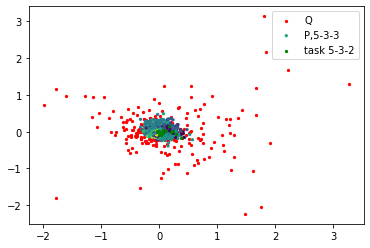

In [54]:
# 5-3-1 Q그리기
plt.scatter(Zp_Q["PCA 1"], Zp_Q["PCA 2"],s=5,c='r', label='Q')
# 5-3-1 P중에서 3-1을 제외한 
plt.scatter(Zp_P["PCA 1"], Zp_P["PCA 2"],s=5, c=[i for i in Zp_P['labels']], label='P,5-3-3') # 5-3-3
# 5-3-2 P중 3-1만
plt.scatter(Zp_3_1["PCA 1"], Zp_3_1["PCA 2"],s=5,c='g', label='task 5-3-2')
plt.legend()

plt.show()

## END